
Github: https://github.com/masam4/DSProject2/tree/main
---



# **Step 1: Data Selection and Exploration (20%)**

Overview of our Project: https://github.com/masam4/DSProject2/blob/main/Final%20Overview.pdf

We picked these datasets because they provide interesting information as everything in our world revolves around consuming or producing energy. It provides a plethora of results on the global energy trends and their far-reaching impacts. Some of the information offered includes the location of the power plants, start date, decommissioning status, types of batteries used, and types of technologies used. These datasets include a section indicating whether the projects have been decommissioned or not, which is the process of closing the facility that provided the energy and provides adequate protection from radiation exposure and isolation from the human environment once the battery or energy source is retired.


# **Step 2: ETL Setup (15%)**

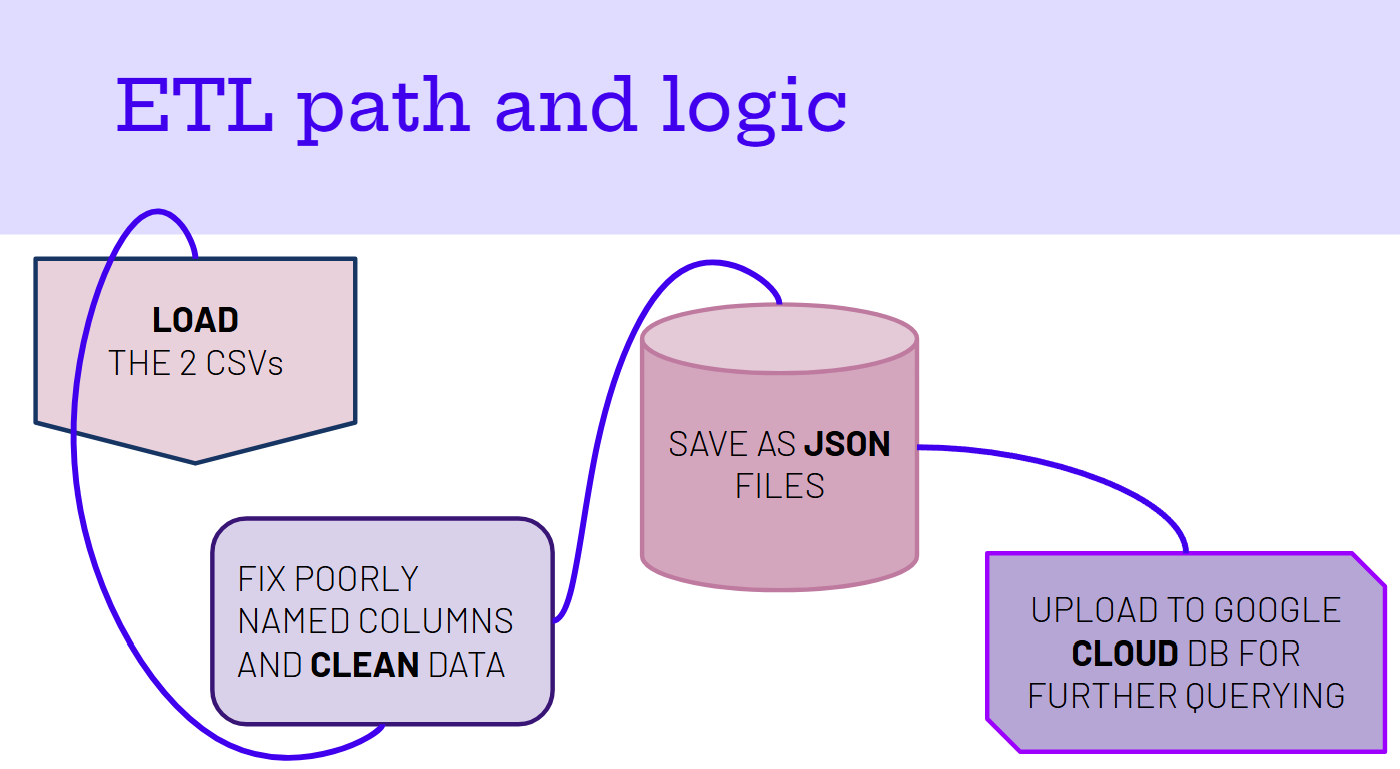

# **Step 3: ETL Implementation (20%)**

#1 Authenticate Google Service Accouunt

Note: you need to create your own service account key and database in google cloud for this logic to work. Must also have your own funds in cloud and correct data loaded.

In [ ]:
import os
import pandas as pd
from google.cloud import storage
from google.cloud import bigquery

# Step 1: Authenticate with Service Account
SERVICE_ACCOUNT_KEY = r"C:\Users\obrie\Documents\Local_Python\DS_2001_Project_2\ds-2001-final-project-ec3f2dea8e7b.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SERVICE_ACCOUNT_KEY

#2 Load CSV's

In [ ]:
# Step 2: Read in CSVs
global_map_data = pd.read_csv('Global_Map_Full_Data_data.csv')
cumulative_sum_data = pd.read_csv('Cummulative_Sum_by_Year_Full_Data_data.csv')

#3 Ensure columns are correct

In [ ]:
 Step 3: Validate Columns
expected_columns_global_map = [
    "Project/Plant Name", "Rated Capacity (kWh)", "Rated Power (kW)",
    "Discharge Duration at Rated Power (hrs)", "Storage Capacity (kWh)"
]

expected_columns_cumulative_sum = [
    "Year", "Subsystem 1 - Technology Broad Category",
    "Subsystem 1 - Technology Mid-Type", "Subsystem 1 - Technology Sub-Type",
    "Rated Power (kW)", "Storage Capacity (kWh)", "Country.1"
]

def validate_columns(df, expected_columns, dataset_name):
    missing_columns = set(expected_columns) - set(df.columns)
    if missing_columns:
        raise ValueError(f"{dataset_name} is missing expected columns: {missing_columns}")
    print(f"All expected columns are present in {dataset_name}.")

validate_columns(global_map_data, expected_columns_global_map, "Global Map Data")
validate_columns(cumulative_sum_data, expected_columns_cumulative_sum, "Cumulative Sum Data")

# 4 Edit column names for understanding and querying

In [ ]:
 Step 4: Rename Columns
global_map_data.rename(columns={
    "Project/Plant Name": "project_name",
    "Rated Capacity (kWh)": "rated_capacity_kwh",
    "Rated Power (kW)": "rated_power_kw",
    "Discharge Duration at Rated Power (hrs)": "discharge_duration_hrs",
    "Storage Capacity (kWh)": "storage_capacity_kwh"
}, inplace=True)
global_map_data_cleaned = global_map_data.drop_duplicates()

cumulative_sum_data.rename(columns={
    "Year": "year",
    "Subsystem 1 - Technology Broad Category": "technology_broad_category",
    "Subsystem 1 - Technology Mid-Type": "technology_mid_type",
    "Subsystem 1 - Technology Sub-Type": "technology_sub_type",
    "Rated Power (kW)": "rated_power_kw",
    "Storage Capacity (kWh)": "storage_capacity_kwh"
}, inplace=True)
columns_to_remove = ["Country.1", "Subsystem 1 - Technology Sub-Type.1"]
cumulative_sum_data_cleaned = cumulative_sum_data.drop(columns=columns_to_remove).drop_duplicates()

cumulative_sum_data_cleaned["storage_capacity_kwh"] = cumulative_sum_data_cleaned["sto

#5 Create bucket to store cleaned data

In [ ]:
 5 create a bucket in the project to store these newly made json files
# also prepare the files to be stored in big query
BUCKET_NAME = "ds-2001-final-bucket"
PROJECT_ID = "ds-2001-final-project"
DATASET_ID = "ABC123"

global_map_json_file = "global_map_data.json"
cumulative_sum_json_file = "cumulative_sum_data.json"

FILES_TO_UPLOAD = [
    (global_map_json_file, "global_map_data.json"),
    (cumulative_sum_json_file, "cumulative_sum_data.json"),
]


client = storage.Client()
try:
    bucket = client.create_bucket(BUCKET_NAME)
    print(f"Bucket {BUCKET_NAME} created.")
except Exception as e:
    print(f"Bucket creation error (if it already exists, this is safe to ignore): {e}")

# **Step 4: Data Analysis (25%)**

#I - Matplotlib Visualization
Using the Cummulative_Sum_by_Year_Full_Data_data.csv, we plot the storage capacity over the years.

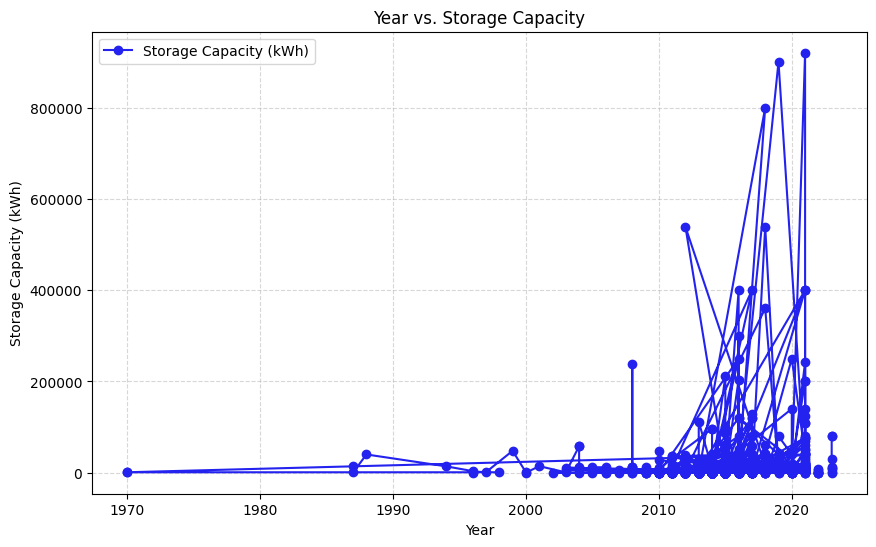

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
file_path = 'Cummulative_Sum_by_Year_Full_Data_data.csv'
data = pd.read_csv(file_path)

# Extract the Year and Storage Capacity columns for plotting
year = data['Year']
storage_capacity = data['Storage Capacity (kWh)']

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(year, storage_capacity, label='Storage Capacity (kWh)', marker='o', color='#2322ef')

plt.title('Year vs. Storage Capacity')
plt.xlabel('Year')
plt.ylabel('Storage Capacity (kWh)')
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

## II - Dataset Mapping with Folium
Using the Global_Map_Full_Data_data.csv, we map locations and power of project.

In [ ]:
import pandas as pd
import folium

energy = pd.read_csv('Global_Map_Full_Data_data.csv')

# Make 'Rated Capacity (kWh)'
energy['marker_size'] = energy['Rated Capacity (kWh)'] / 1000000

# Create folium map
map_energy = folium.Map(location=[36, -119], zoom_start=6)

# Add varying marker sizes to the map
for _, row in energy.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['marker_size'],
        popup=f"Capacity (kWh): ${row['Rated Capacity (kWh)']} | Power (kW): {row['Rated Power (kW)']:.1f}",
        color="blue",
        fill=True,
        fill_color="blue"
    ).add_to(map_energy)

map_energy

## III - Heatmap with Seaborn
Using the Global_Map_Full_Data_data.csv, we indicate correlation between factors.

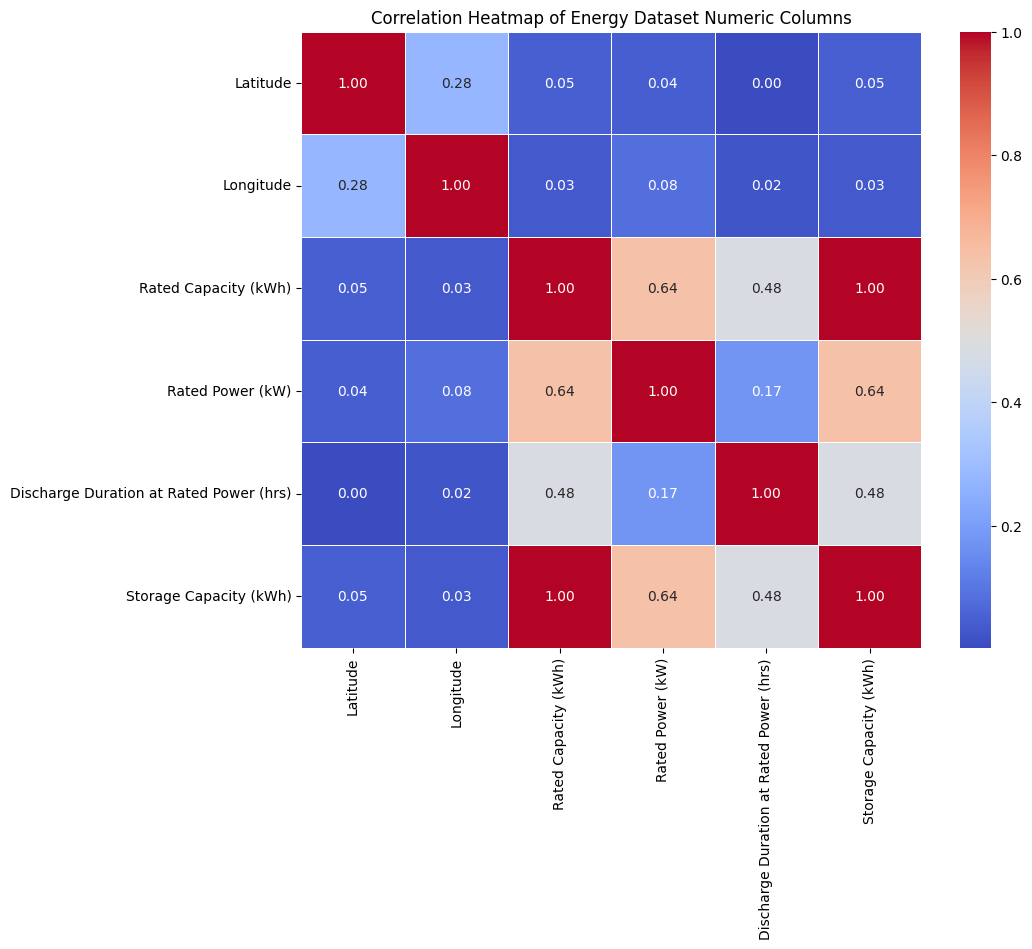

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

energy = pd.read_csv('Global_Map_Full_Data_data.csv')
valid_numeric_data = energy.select_dtypes(include=['float64', 'int64'])

# Clean the numeric data by dropping invalid entries
valid_numeric_data = valid_numeric_data.apply(pd.to_numeric, errors='coerce').dropna()
correlation_matrix = valid_numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Energy Dataset Numeric Columns')
plt.show()


# **Step 5: Cloud Storage and Documentation (10%)**

Continued number 6 after Step: 3: Data Implementation

#6 Store data in google cloud using created bucket


In [ ]:
# 6 upload the files to google cloud

for local_file, cloud_file in FILES_TO_UPLOAD:
    try:
        bucket = client.bucket(BUCKET_NAME)
        blob = bucket.blob(cloud_file)
        blob.upload_from_filename(local_file)
        print(f"File {local_file} uploaded to {cloud_file} in bucket {BUCKET_NAME}.")
    except Exception as e:
        print(f"Failed to upload {local_file} to GCS: {e}")

# 7 Load Json files into Bigquery for further analysis

In [ ]:
# Step 7, load JSON files into BigQuery
client = bigquery.Client()
TABLES = {
    "global_map_data": f"gs://{BUCKET_NAME}/global_map_data.json",
    "cumulative_sum_data": f"gs://{BUCKET_NAME}/cumulative_sum_data.json",
}

for table_name, file_path in TABLES.items():
    try:
        table_id = f"{PROJECT_ID}.{DATASET_ID}.{table_name}"
        job_config = bigquery.LoadJobConfig(
            source_format=bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
            autodetect=True,
            write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        )
        load_job = client.load_table_from_uri(file_path, table_id, job_config=job_config)
        load_job.result()
        print(f"Loaded data into BigQuery table {table_id}.")
    except Exception as e:
        print(f"Failed to load data into BigQuery table {table_name}: {e}")

# **Step 6: Reflection Paper (5%)**

https://github.com/masam4/DSProject2/blob/main/Final%20Reflections.pdf

# **Step 7: Presentation (5%)**

https://github.com/masam4/DSProject2/blob/main/Final%20Presentation.pdf